# Capstone Project - The Battle of Neighborhoods

### Notebook for the battle of the Neighborhoods Capstone. We will be exploring the Foursquare API data and how to apply it to a business problem. 

## Business Problem

### We will be exploring the Washington D.C. area in order to assist in informing our client the best location for opening a high-end French restuarant. We will identify a location in D.C. that explores the area for other restaurants, other French restaurants, and the median income of the area and surrounding areas, based on median income data from Census. Our stakeholders include not only our client, but also the customers who will be eating there, and an exploration of available transportation in the area will also be explored.

## Data 

### The three following data sets will be used to arrive at a conclusino for the best location for a high-end Frech restaurant based on competition, median income, and available transportation in the area:

### Foursquare Data: We will use the Foursquare API to explore French restaurant locations in D.C. and pick a location that has little competition for out stakeholder (client).

### Census Data: We will use 2010 Census data in order to find the median income by Census block, and use this to find the areas with the highest income, so the restaurant can experience the highest traffic possible given the high price point of the food.

### DC Open Data Transporation: We will use the DC Open Data portal in order to find transportation in the area that will make it easier for one of our stakeholders (customers) to get there.

## Data Wrangling

### Foursquare

In [1]:
import requests 
import pandas as pd
import numpy as np 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium

import config as keys

# Foursquare API info
CLIENT_ID = keys.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = keys.CLIENT_SECRET # your Foursquare Secret
VERSION = '20180604'

In [2]:
dc_center = (38.942900, -77.030364)

latitude, longitude = dc_center[0], dc_center[1]

radius = 5000

categoryId = '4bf58dd8d48988d10c941735' # French restaurant Foursquare ID

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(CLIENT_ID, 
                                                                                                                               CLIENT_SECRET, 
                                                                                                                               latitude, 
                                                                                                                               longitude, 
                                                                                                                               VERSION, 
                                                                                                                               categoryId, 
                                                                                                                               radius)

results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
french_venues = pd.json_normalize(venues)
french_df = french_venues.drop(['categories', 'referralId', 'hasPerk', 'location.crossStreet', 'location.distance', 'location.cc', 'location.labeledLatLngs', 'location.formattedAddress', 'delivery.id', 'delivery.url', 'delivery.provider.name', 'delivery.provider.icon.prefix', 'delivery.provider.icon.sizes', 'delivery.provider.icon.name', 'venuePage.id'], axis=1)
french_df.columns = ['id', 'name', 'address', 'lat', 'lon', 'zip', 'city', 'state', 'country']

#### Request venue specific data from list of derived French restaurants in D.C.

In [3]:
# french_df.id[0]

# VENUE_ID = french_df.id[0]


# url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(VENUE_ID,CLIENT_ID, CLIENT_SECRET, VERSION)

# results = requests.get(url).json()

# results

In [4]:
# venue_stats = []

# i = 0

# for i in range(len(french_df)):
    
#     VENUE_ID = french_df.id[i]
#     url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VENUE_ID, CLIENT_ID, CLIENT_SECRET, VERSION)
    
#     results = requests.get(url).json()
    
#     # assign relevant part of JSON to venue_stats
#     venue_stats = results['response']

In [5]:
# Load in data - API URL JSON
metro_map = folium.Map(location=[38.932645,-76.984256], 
                       zoom_start = 12, 
                       tiles = keys.mapbox_tile,
                       attr = 'Navigation'
                       )

for label, lat, lng in zip(french_df['name'], french_df['lat'], french_df['lon']):
    folium.Marker(
        [lat, lng],
        radius=5,
        color='red',
        icon=folium.Icon(color='green'),
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(metro_map)

### DC Open Data - Metro Stations

In [6]:
# Load in data - API URL GeoJSON
metro_url = 'https://opendata.arcgis.com/datasets/ab5661e1a4d74a338ee51cd9533ac787_50.geojson'

folium.GeoJson(metro_url, tooltip=folium.features.GeoJsonTooltip(fields= ['NAME', 'LINE', 'ADDRESS'])).add_to(metro_map)

### Census - Median Incomes by Census Tract

In [7]:
# API URL GeoJSON

median_url = 'https://opendata.arcgis.com/datasets/0ccdf1f2d4fe4a5391899c595fd2e02c_0.geojson'

median_data = pd.read_csv('dc_data/median.csv')

bins = list(median_data['Median_Income'].quantile([0, 0.25, 0.5, 0.75, 1]))

# folium.GeoJson(median_url, name='geojson').add_to(metro_map)

choro = folium.Choropleth(geo_data = median_url,
                   name = 'median_chloro',
                   data = median_data,
                   columns = ['NAME', 'Median_Income'],
                   key_on = 'feature.properties.NAME',
                   fill_color = 'PuBuGn',
                   fill_opacity = 0.7,
                   line_opacity = 0.5,
                   legend_name = 'Median Income Past 12 Months',
                   bins = bins).add_to(metro_map)

folium.GeoJsonPopup(fields = ['NAME', 'B19049_001E'], aliases = ['Name', 'Median Income']).add_to(choro.geojson)

metro_map

#### Obtaining geopandas dataframes of geojson files and restaurant lat longs

In [8]:
import geopandas as gpd

# Metro Stations Dataframe
metro_geo = gpd.read_file(metro_url)[['NAME','geometry']]


# Median Income Dataframe, filling missing values with median
median_geo = gpd.read_file(median_url)[['NAME', 'B19049_001E', 'geometry']]

median_geo.columns = ['name', 'median_income', 'geometry']

median_geo = median_geo.fillna(median_geo['median_income'].median())


# Frech restaurants df
french_geo = gpd.GeoDataFrame(french_df, geometry=gpd.points_from_xy(french_df['lon'], french_df['lat']))

#### Spatially joining metro and restaurants locations to Census Tracts to get sums by individual tract

In [9]:
# Join metro stations to Census tracts, groupby Census tracts
metro_joined = gpd.sjoin(metro_geo, median_geo, op="within")

census_metro_sum = metro_joined.groupby('name').size()

# Merge with Census tract dataframe and clean up
median_geo = median_geo.merge(census_metro_sum.to_frame(),
                              on = 'name', 
                              how = 'outer')

median_geo.rename(columns={0:'metro_sum'}, 
                  inplace = True)

median_geo.fillna(0, inplace = True)


# Join restaurants to Census tracts, groupby Census tracts, and merge with Census tract dataframe
french_joined = gpd.sjoin(french_geo, median_geo, op="within")

census_french_sum = french_joined.groupby('name_right').size()

# Merge with Census tract dataframe and clean up
median_geo = median_geo.merge(census_french_sum.to_frame(), 
                              left_on = 'name', 
                              right_on = 'name_right', 
                              how = 'outer')

median_geo.rename(columns={0:'french_sum'}, 
                  inplace = True)

median_geo.fillna(0, inplace = True)


/home/rb/.virtualenvs/clustering/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [10]:
# Add column of median centroids and set as geoemtry column for geodataframe

median_geo['centroids'] = median_geo['geometry'].centroid

median_geo = median_geo.set_geometry('centroids')

In [11]:
latitudes = list(median_geo.geometry.y)
longitudes = list(median_geo.geometry.x)
labels = list(median_geo.name)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='red', icon='info-sign')
     ).add_to(metro_map) 

metro_map

In [12]:
median_geo

name  median_income  \
0       Census Tract 1       191146.0   
1    Census Tract 2.01        84375.0   
2    Census Tract 2.02       170987.0   
3       Census Tract 3       152120.0   
4       Census Tract 4       126731.0   
..                 ...            ...   
174   Census Tract 107        73688.0   
175   Census Tract 108        45278.0   
176   Census Tract 109        41660.0   
177   Census Tract 110        84375.0   
178   Census Tract 111        79628.0   

                                              geometry  metro_sum  french_sum  \
0    MULTIPOLYGON (((-77.06470 38.89188, -77.06469 ...        0.0         3.0   
1    POLYGON ((-77.07310 38.91260, -77.07306 38.911...        0.0         0.0   
2    MULTIPOLYGON (((-77.06946 38.90063, -77.06938 ...        0.0         2.0   
3    POLYGON ((-77.07320 38.92255, -77.07291 38.922...        0.0         0.0   
4    POLYGON ((-77.06639 38.93147, -77.06640 38.930...        0.0         0.0   
..                                                 ...        ...         ...   
174  POLYGON ((-77.03653 38.90703, -77.03654 38.905...        8.0         3.0   
175  POLYGON ((-77.03946 38.89882, -77.03947 38.898...        0.0         0.0   
176  MULTIPOLYGON (((-77.02179 38.80589, -77.02172 ...        0.0         0.0   
177  POLYGON ((-77.01521 38.87647, -77.01508 38.876...        0.0         0.0   
178  POLYGON ((-76.95884 38.93160, -76.95879 38.931...        0.0         0.0   

                      centroids  
0    POINT (-77.06058 38.90796)  
1    POINT (-77.07433 38.90921)  
2    POINT (-77.06796 38.90803)  
3    POINT (-77.07561 38.91757)  
4    POINT (-77.06590 38.92386)  
..                          ...  
174  POINT (-77.04198 38.90401)  
175  POINT (-77.04461 38.89736)  
176  POINT (-77.01647 38.81667)  
177  POINT (-77.01715 38.87027)  
178  POINT (-76.96685 38.91678)  

[179 rows x 6 columns]

#### Create dataframe to perform clustering on

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

median_scaled = median_geo.drop(['name', 'geometry', 'centroids'], 1)

# Rescale dataframe using MinMax
scalar = MinMaxScaler()

median_scaled = scalar.fit_transform(median_scaled)

In [14]:
# Perform cluster analysis
k = 3

kmeans = KMeans(n_clusters = k, random_state = 42).fit(median_scaled)

kmeans.labels_.shape

(179,)

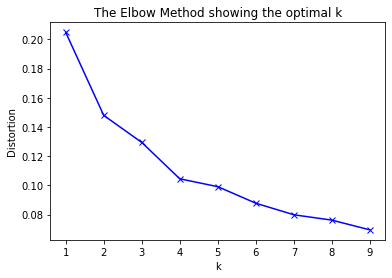

In [15]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k).fit(median_scaled)
    kmean.fit(median_scaled)
    distortions.append(sum(np.min(cdist(median_scaled, kmean.cluster_centers_, 'euclidean'), axis=1)) / median_scaled.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
# Join cluster labels to Census tract dataframe
median_geo['cluster'] = pd.Series(kmeans.labels_, index = median_geo.index)
median_geo

name  median_income  \
0       Census Tract 1       191146.0   
1    Census Tract 2.01        84375.0   
2    Census Tract 2.02       170987.0   
3       Census Tract 3       152120.0   
4       Census Tract 4       126731.0   
..                 ...            ...   
174   Census Tract 107        73688.0   
175   Census Tract 108        45278.0   
176   Census Tract 109        41660.0   
177   Census Tract 110        84375.0   
178   Census Tract 111        79628.0   

                                              geometry  metro_sum  french_sum  \
0    MULTIPOLYGON (((-77.06470 38.89188, -77.06469 ...        0.0         3.0   
1    POLYGON ((-77.07310 38.91260, -77.07306 38.911...        0.0         0.0   
2    MULTIPOLYGON (((-77.06946 38.90063, -77.06938 ...        0.0         2.0   
3    POLYGON ((-77.07320 38.92255, -77.07291 38.922...        0.0         0.0   
4    POLYGON ((-77.06639 38.93147, -77.06640 38.930...        0.0         0.0   
..                                                 ...        ...         ...   
174  POLYGON ((-77.03653 38.90703, -77.03654 38.905...        8.0         3.0   
175  POLYGON ((-77.03946 38.89882, -77.03947 38.898...        0.0         0.0   
176  MULTIPOLYGON (((-77.02179 38.80589, -77.02172 ...        0.0         0.0   
177  POLYGON ((-77.01521 38.87647, -77.01508 38.876...        0.0         0.0   
178  POLYGON ((-76.95884 38.93160, -76.95879 38.931...        0.0         0.0   

                      centroids  cluster  
0    POINT (-77.06058 38.90796)        1  
1    POINT (-77.07433 38.90921)        0  
2    POINT (-77.06796 38.90803)        2  
3    POINT (-77.07561 38.91757)        2  
4    POINT (-77.06590 38.92386)        2  
..                          ...      ...  
174  POINT (-77.04198 38.90401)        1  
175  POINT (-77.04461 38.89736)        0  
176  POINT (-77.01647 38.81667)        0  
177  POINT (-77.01715 38.87027)        0  
178  POINT (-76.96685 38.91678)        0  

[179 rows x 7 columns]

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], 
                          zoom_starts = 12, 
                          tiles = keys.mapbox_tile,  
                          attr = 'Navigation'
                         )

latitudes = list(median_geo.geometry.y)
longitudes = list(median_geo.geometry.x)
labels = list(median_geo.name)
clusters = list(median_geo.cluster)



choro = folium.Choropleth(geo_data = median_url,
                   name = 'median_chloro',
                   data = median_data,
                   columns = ['NAME', 'Median_Income'],
                   key_on = 'feature.properties.NAME',
                   fill_color = 'PuBuGn',
                   fill_opacity = 0.7,
                   line_opacity = 0.5,
                   legend_name = 'Median Income Past 12 Months',
                   bins = bins).add_to(map_clusters)

folium.GeoJsonPopup(fields = ['NAME', 'B19049_001E'], aliases = ['Name', 'Median Income']).add_to(choro.geojson)


# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for lat, lng, label, cluster in zip(latitudes, longitudes, labels, clusters):
    label = '{}, {}'.format(label, cluster)
    label = folium.Popup(str(label) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.2).add_to(map_clusters)
    
map_clusters

In [18]:
median_geo[(median_geo.cluster == 1)]

name  median_income  \
0      Census Tract 1       191146.0   
75    Census Tract 55       100982.0   
77    Census Tract 58       143268.0   
168  Census Tract 101        94250.0   
169  Census Tract 102       109844.0   
174  Census Tract 107        73688.0   

                                              geometry  metro_sum  french_sum  \
0    MULTIPOLYGON (((-77.06470 38.89188, -77.06469 ...        0.0         3.0   
75   MULTIPOLYGON (((-77.05585 38.90476, -77.05593 ...        2.0         3.0   
77   POLYGON ((-77.02192 38.90295, -77.02192 38.902...       14.0         5.0   
168  POLYGON ((-77.03154 38.90551, -77.03082 38.905...        3.0         3.0   
169  POLYGON ((-77.01755 38.88758, -77.01756 38.887...        7.0         1.0   
174  POLYGON ((-77.03653 38.90703, -77.03654 38.905...        8.0         3.0   

                      centroids  cluster  
0    POINT (-77.06058 38.90796)        1  
75   POINT (-77.04919 38.90764)        1  
77   POINT (-77.02503 38.89787)        1  
168  POINT (-77.03184 38.90270)        1  
169  POINT (-77.02333 38.88277)        1  
174  POINT (-77.04198 38.90401)        1

In [19]:
median_geo[(median_geo.cluster == 2)]

name  median_income  \
2     Census Tract 2.02       170987.0   
3        Census Tract 3       152120.0   
4        Census Tract 4       126731.0   
5     Census Tract 5.01       116303.0   
6     Census Tract 5.02       142750.0   
..                  ...            ...   
139  Census Tract 93.01        97813.0   
141     Census Tract 94        96953.0   
143  Census Tract 95.03       118039.0   
161  Census Tract 99.01        96518.0   
173    Census Tract 106       107607.0   

                                              geometry  metro_sum  french_sum  \
2    MULTIPOLYGON (((-77.06946 38.90063, -77.06938 ...        0.0         2.0   
3    POLYGON ((-77.07320 38.92255, -77.07291 38.922...        0.0         0.0   
4    POLYGON ((-77.06639 38.93147, -77.06640 38.930...        0.0         0.0   
5    MULTIPOLYGON (((-77.05287 38.91998, -77.05287 ...        2.0         0.0   
6    POLYGON ((-77.05677 38.93258, -77.05673 38.932...        0.0         0.0   
..                                                 ...        ...         ...   
139  POLYGON ((-76.97913 38.92772, -76.97913 38.927...        1.0         1.0   
141  POLYGON ((-76.97372 38.94324, -76.97363 38.943...        0.0         0.0   
143  POLYGON ((-76.98575 38.95265, -76.98552 38.952...        0.0         0.0   
161  POLYGON ((-76.94577 38.88088, -76.94590 38.880...        0.0         0.0   
173  POLYGON ((-77.00533 38.90922, -77.00510 38.909...        4.0         0.0   

                      centroids  cluster  
2    POINT (-77.06796 38.90803)        2  
3    POINT (-77.07561 38.91757)        2  
4    POINT (-77.06590 38.92386)        2  
5    POINT (-77.05172 38.92659)        2  
6    POINT (-77.05956 38.92836)        2  
..                          ...      ...  
139  POINT (-76.98646 38.93076)        2  
141  POINT (-76.97425 38.93681)        2  
143  POINT (-76.98453 38.94345)        2  
161  POINT (-76.95534 38.87535)        2  
173  POINT (-77.00331 38.90332)        2  

[73 rows x 7 columns]

In [20]:
median_geo[(median_geo.cluster == 0)].median_income.mean()

54470.3